# 1. Setup

In [1]:
from time import time

from catboost import CatBoostRegressor
import lightgbm as lgbm
from scipy.interpolate import CubicSpline
from scipy.stats import entropy, gaussian_kde
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
import shap
import sklearn as skl
import xgboost as xgb

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
# %%bash
# # t=0:07
# path=../data/nhts/2017
# mkdir -p $path; cd $path
# url="https://nhts.ornl.gov/assets/2016/download/csv.zip"
# wget $url
# unzip csv.zip

## 2.2. Load trips

In [3]:
# t=0:08
tripUS = pd.read_csv('../data/nhts/trippub.csv').rename(columns=str.lower).disp()

923,572 rows x 115 cols; Memory: 1037.8 MiB


houseid personid tdtrpnum strttime  endtime trvlcmin   trpmiles trptrans  \
    <int64>  <int64>  <int64>  <int64>  <int64>  <int64>  <float64>  <int64>   
0  30000007        1        1     1000     1015       15      5.244        3   

  trpaccmp trphhacc  ... obhtnrnt obppopdn  obresdn dthtnrnt dtppopdn  \
   <int64>  <int64>  ...  <int64>  <int64>  <int64>  <int64>  <int64>   
0        0        0  ...       20      750      300       50      750   

   dtresdn dteempdn dbhtnrnt dbppopdn  dbresdn  
   <int64>  <int64>  <int64>  <int64>  <int64>  
0      300      350       30      300      300  

[2 rows x 115 columns]

In [4]:
def get_trip_data(trip=tripUS):
    df = Pdf()
    def cut(col: str, bins: list[float], labels: list[str]) -> pd.Categorical:
        return pd.cut(trip[col], [-INF] + bins + [INF], True, labels)
    def classify(col: str, mapping: dict) -> pd.Categorical:
        cats = Series(list(mapping.values())).drop_duplicates().to_list()
        return pd.Categorical(trip[col].map(mapping), categories=cats)
    ## Deterrence measures
    df['Distance'] = trip['trpmiles'] * MI2M / 1000 # in km
    df['Duration'] = trip['trvlcmin'] # in minutes
    df['Speed'] = (df.Distance / (df.Duration / 60)) # in km/h
    for col, vmax in D(Distance=200, Duration=120, Speed=100).items():
        df.loc[(df[col] <= 0) | (df[col] > vmax), col] = np.nan
    df['LogDistance'] = np.log10(1 + df.Distance * 1000) # distance in meters
    # estimated gas price in $ assuming a constant mileage of 20 mi/ga
    # df['Cost'] = (trip['gasprice'] / 100) * (df.Distance * 1000 / MI2M) / 20
    df['TripWeight'] = normalize(trip['wttrdfin'])
    ## Trip attributes
    df['Mode'] = classify('trptrans', {x: 'drive' for x in [3, 4, 5, 6, 17, 18]} | 
                                      {x: 'transit' for x in [10, 11, 12, 13, 14, 15, 16]} |
                                      {1: 'walk', 2: 'bike'})
    df['HomeBased'] = (trip['trippurp'] == 'NHB').map({False: 'yes', True: 'no'})
    df['Purpose'] = classify('whytrp90', {1: 'work', 2: 'work', 3: 'shopping',
                                          4: 'social', 5: 'school/church', 6: 'medical',
                                          8: 'social', 10: 'recreation'})
    df['Weekend'] = classify('tdwknd', {1: 'yes', 2: 'no'})
    df['Occupancy'] = cut('numontrp', [1, 2], ['single', 'pair', 'multiple'])
    df['GasPrice'] = cut('gasprice', [233, 267], ['low', 'mid', 'high'])
    df['StartTime'] = (pd.cut(trip['strttime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'off_peak', 'morn_peak', 'off_peak', 'eve_peak', 'off_peak'], ordered=False)
                       .cat.reorder_categories(['morn_peak', 'eve_peak', 'off_peak']))
    df['StayTime'] = cut('dweltime', [60, 480], ['short', 'mid', 'long'])
    ## SES of respondent/household
    df['Age'] = normalize(trip['r_age'].clip(0, 80))
    df['AgeGrp'] = cut('r_age', [0, 30, 64], ['n/a', 'young', 'mid', 'senior'])
    df['Sex'] = classify('r_sex', {1: 'male', 2: 'female'})
    df['Race'] = classify('hh_race', {1: 'white'} | {x: 'nonwhite' for x in [2, 3, 4, 5, 6]})
    df['Hispanic'] = classify('hh_hisp', {1: 'yes', 2: 'no'})
    df['Education'] = cut('educ', [0, 2], ['n/a', 'school', 'college'])
    df['Worker'] = classify('worker', {1: 'yes', 2: 'no'})
    df['Income'] = cut('hhfaminc', [0, 5, 7], ['n/a', 'low', 'mid', 'high'])
    df['HomeOwn'] = classify('homeown', {1: 'own', 2: 'rent'})
    ## Origin/destination attributes
    df['Region'] = cut('census_r', [1, 2, 3], ['northeast', 'midwest', 'south', 'west'])
    df['MSAKind'] = classify('msacat', {1: 'big_rail', 2: 'big_norail', 3: 'small', 4: 'not_msa'})
    df['UrbanO'] = classify('obhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['UrbanD'] = classify('dbhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['PopDensityO'] = cut('otppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['PopDensityD'] = cut('dtppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityO'] = cut('otresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityD'] = cut('dtresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityO'] = cut('oteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityD'] = cut('dteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    ## Remove bad dataa
    df = df.replace('n/a', None)
    print('NaNs: ' + ' '.join([f'{k}={v:,}' for k, v in df.isna().sum().items() if v > 0]))
    df = df.dropna()
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype(CAT)
    return df

data = get_trip_data().disp(2)

NaNs: Distance=9,530 Duration=13,345 Speed=19,562 LogDistance=9,530 Mode=9,540 Purpose=35,779 StartTime=544 AgeGrp=1,216 Sex=711 Race=19,553 Hispanic=1,002 Education=65,579 Worker=79,323 Income=24,340 HomeOwn=6,308 UrbanO=980 UrbanD=962 PopDensityO=973 PopDensityD=955 HouseDensityO=973 HouseDensityD=955 EmpDensityO=973 EmpDensityD=955
739,304 rows x 32 cols; Memory: 57.8 MiB


Distance   Duration      Speed LogDistance TripWeight        Mode  \
   <float64>  <float64>  <float64>   <float64>  <float64>  <category>   
0   8.439379       15.0  33.757516    3.926362   0.006319       drive   
1   8.286492       20.0  24.859475    3.918423   0.006319       drive   

    HomeBased        Purpose     Weekend   Occupancy  ...      Region  \
   <category>     <category>  <category>  <category>  ...  <category>   
0         yes  school/church          no      single  ...       south   
1         yes  school/church          no      single  ...       south   

      MSAKind      UrbanO      UrbanD PopDensityO PopDensityD HouseDensityO  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0       small    suburban    suburban         mid         low           mid   
1       small    suburban    suburban         low         mid           low   

  HouseDensityD EmpDensityO EmpDensityD  
     <category>  <category>  <category>  
0           low         mid         low  
1           mid         low         mid  

[3 rows x 32 columns]

# Basic analysis

In [5]:
# for col in sorted(data.select_dtypes(CAT).columns):
#     print('*' * 50, f'{col}', sep='\n') #  (n={data[col].dropna().size:,})
#     print(', '.join([f'{k}={v:,}' for k, v in data[col].value_counts().sort_index().items()]))

## 2.3 Target vars (deterrence)

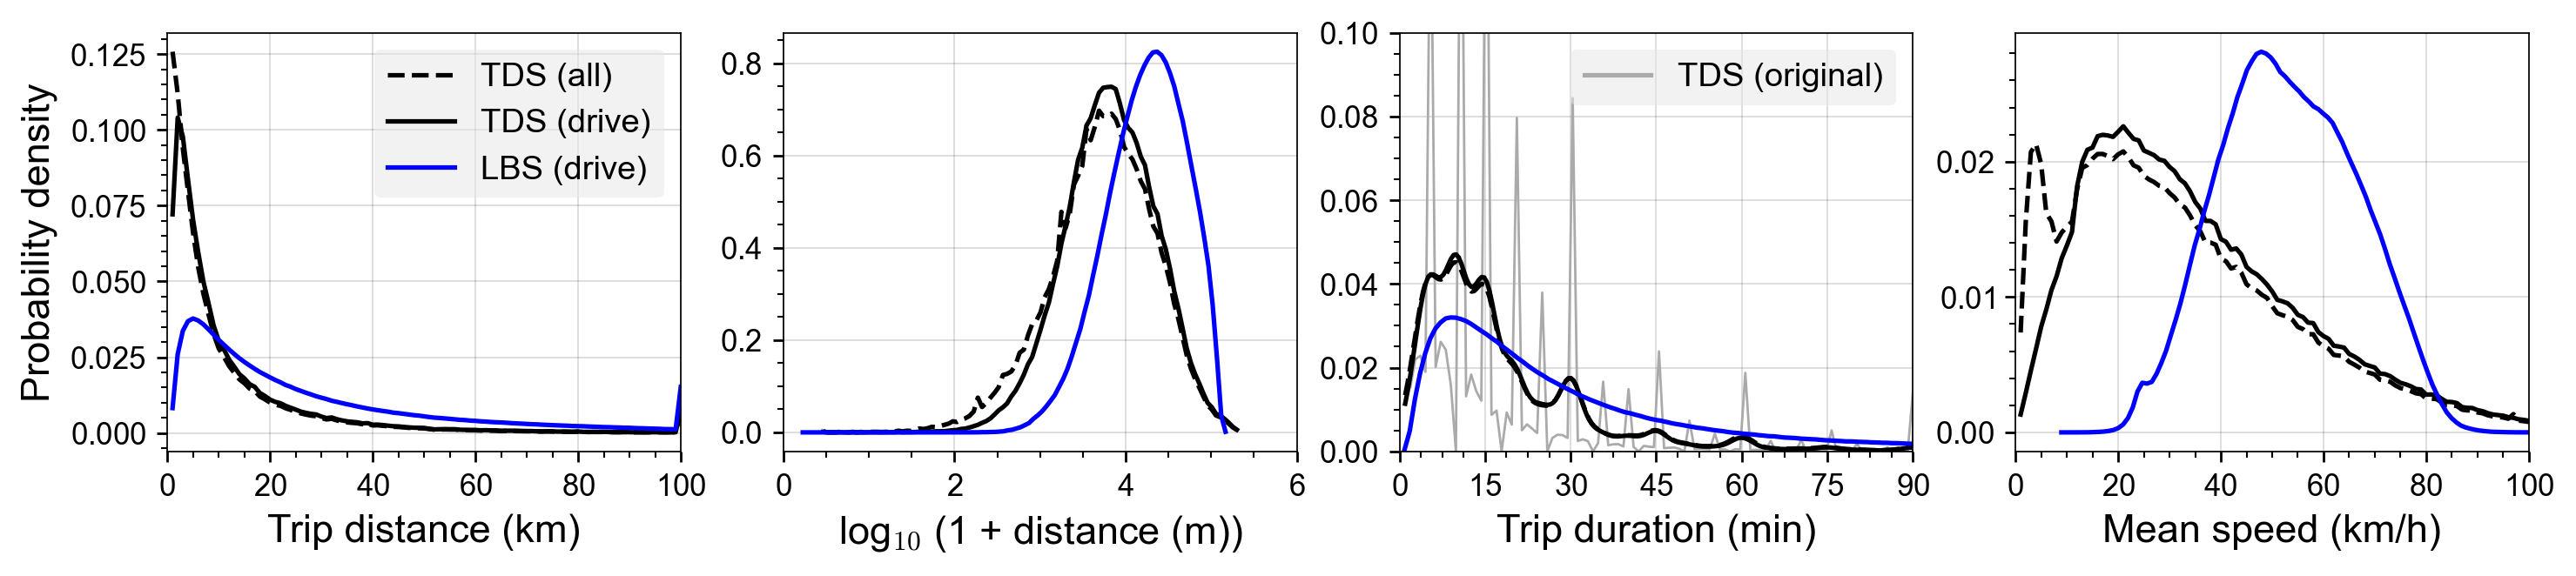

In [6]:
def fig_deterrence_distr(tds=data, size=(14, 2.5), dpi=150):
    sg = pd.read_parquet('../data/pois/odm2.parquet', filters=[
        ('duration', '>', 0), ('purpose', '==', 'Overall')
    ], columns=['visitors', 'distance', 'duration'])
    sg.distance /= 1000; sg.duration /= 60
    sg['speed'] = sg.distance / sg.duration * 60
    def hist(x, vmax=None, bins=100, wt=None):
        y, x = np.histogram(x.clip(0, vmax), bins, density=True, weights=wt)
        return x[1:], y
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi)
    drive = tds.query('Mode == "drive"')
    ## Distance
    ax = pplot(axes[0], ylog=0, xlab='Trip distance (km)',
               ylab='Probability density', xlim=(0, 100))
    ax.plot(*hist(tds.Distance, 100), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.Distance, 100), color='k', label='TDS (drive)')
    ax.plot(*hist(sg.distance, 100), color='b', label='LBS (drive)')
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color=c, ls=ls, label=x) for x, c, ls in [
            ('TDS (all)', 'k', '--'), ('TDS (drive)', 'k', '-'), 
            ('LBS (drive)', 'b', '-')]])
    ## LogDistance
    ax = pplot(axes[1], ylog=0, xlab='log$_{10}$ (1 + distance (m))',
               ylab='Probability density', xlim=(0, 6))
    ax.plot(*hist(tds.LogDistance, 100), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.LogDistance, 100), color='k', label='TDS (drive)')
    ax.plot(*hist(np.log10(1 + sg.distance * 1000), 100), color='b', label='LBS (drive)')
    ax.set_ylabel('')
    ## Duration
    ax = pplot(axes[2], xlab='Trip duration (min)', ylim=(0, 0.1), xlim=(0, 90))
    ax.plot(*hist(tds.Duration, 90), color='#aaa', lw=0.8, label='TDS (original; all)')
    ax = sns.kdeplot(tds.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', ls='--', label='TDS (smooth; all)')
    ax = sns.kdeplot(drive.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', label='TDS (smooth; drive)')
    ax.set_ylabel('')
    ax.plot(*hist(sg.duration, 90), color='b', label='LBS (drive)')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color='#aaa', label='TDS (original)')])
    ## Speed
    ax = pplot(axes[3], xlab='Mean speed (km/h)', xlim=(0, 100))
    ax.plot(*hist(tds.Speed), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.Speed), color='k', label='TDS (drive)')
    ax.plot(*hist(sg.speed), color='b', label='LBS (drive)')

x = fig_deterrence_distr(dpi=250); x # t=0:09

## Covariates (discrete vars)

### Sample sizes

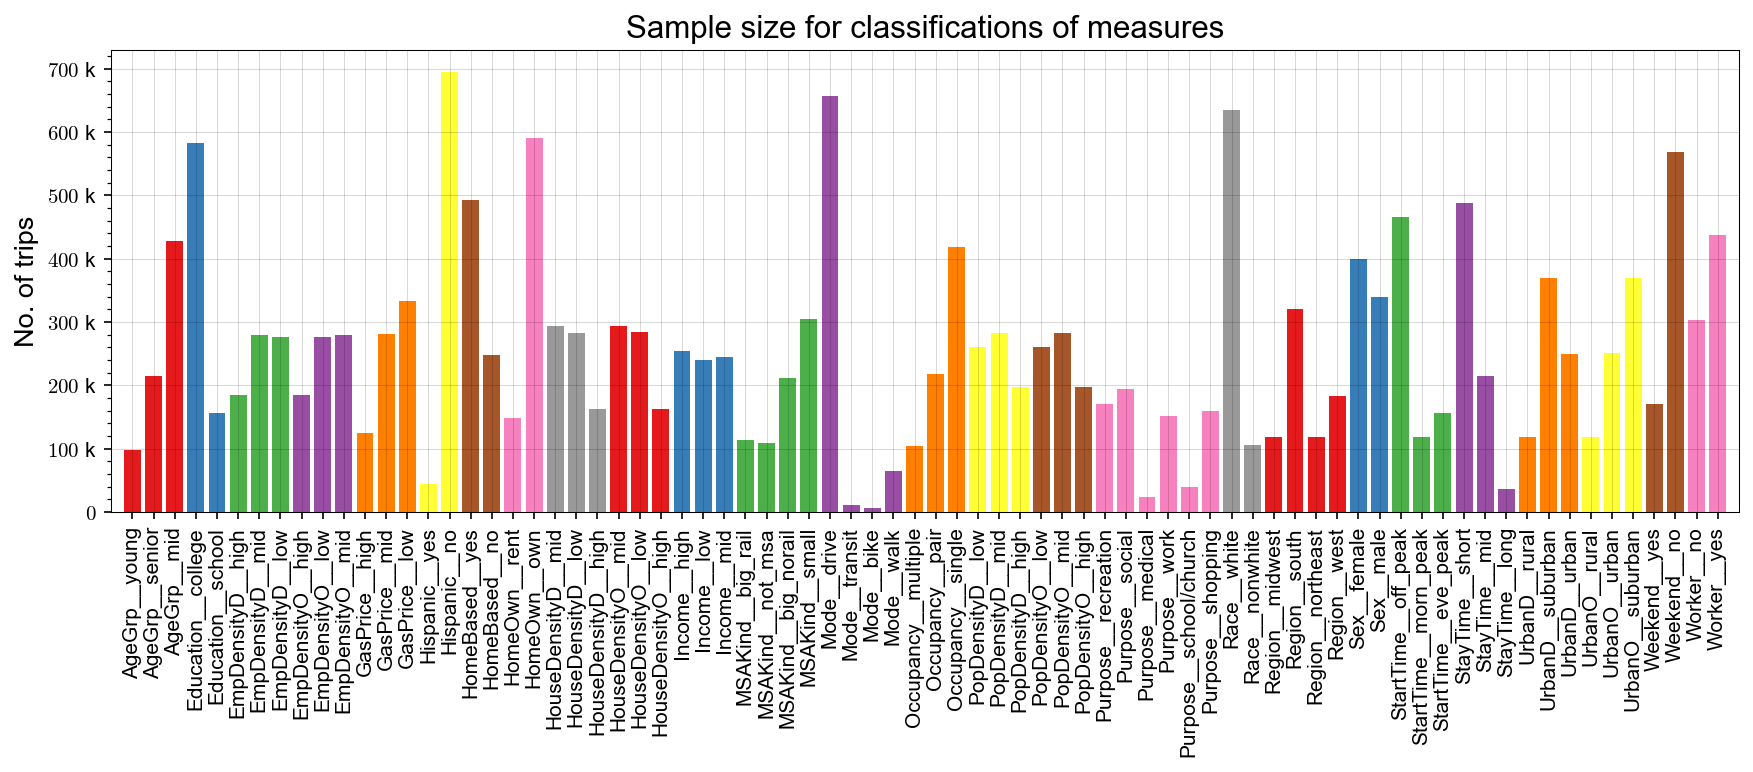

In [7]:
def plot_sample_sizes(data, size=(14, 4), dpi=150):
    df = pd.concat([data[col].value_counts().rename_axis('subcat')
                    .reset_index().assign(cat=col) 
                    for col in data.select_dtypes(CAT)])
    df = df.sort_values('cat')
    df['label'] = df.cat + '__' + df.subcat
    df['color'] = df.cat.map(dict(zip(df.cat.unique(), sns.color_palette(
        'Set1', df.cat.nunique()))))
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', xlim=(-1, len(df)), 
               title='Sample size for classifications of measures', yeng=1)
    ax.bar(df.label, df['count'], color=df.color)
    ax.tick_params(which='minor', bottom=False)
    plt.xticks(rotation=90)

plot_sample_sizes(data, dpi=150)

# 4. Find important features

## Interactive distributions

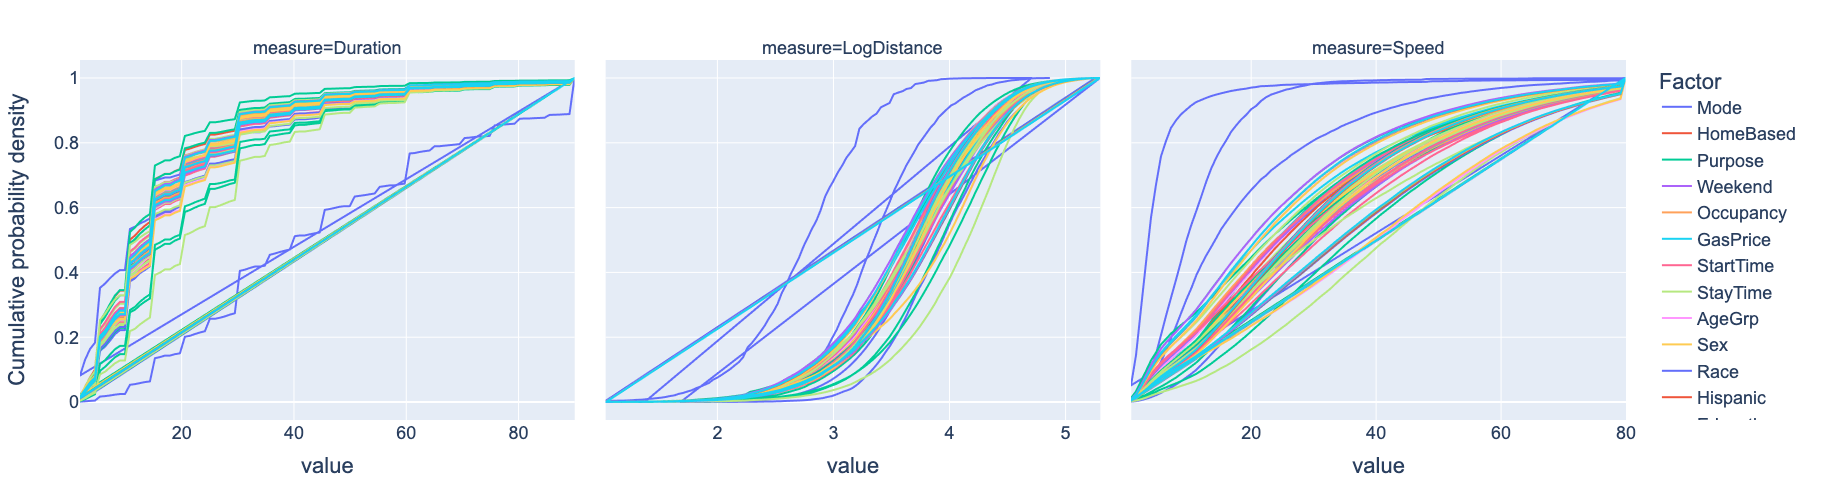

In [8]:
def plot_distr_vars(data=data, width=1600, height=500):
    res = []
    for measure, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 1, 6), ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                y, x = np.histogram(df[measure].clip(vmin, vmax), bins=100)
                y = (y / y.sum()).cumsum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, measure=measure))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='measure',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

plot_distr_vars()

**Insights** from the distribution plots

**Major differences**:
- `mode` is the strongest determinant for trip length, with transit & driving trips much much longer than biking and walking trips. The trip duration distribution is pretty similar for driving, biking & walking, but transit trips take much more time.
    - `msakind`: Bigger MSAs travel longer than smaller places, esp. if they have subway systems
- `purpose`: Work and medical trips are the longest
    - similarly, `homebased` trips are longer than non-home-based
    - also, `workers` travel longer than non-workers
- `race`: Interestingly, people of color take much longer to travel than White people even though they cover nearly the same distances
    - `income`: Low-income people travel shorter distances even though they take nearly the same time as middle and high-income folks.
- `stay` duration: Longer stay warrants longer trips
- `ruralO`: People in rural areas travel much longer than urban folks
    - `ruralD`: Similarly, people going to rural areas travel longer than in urban destinations
    - `popdensity{O,D}`, `housedensity{O,D}`, `empdensity{O,D}`: Trips to and from low-density regions are much longer than between high-density regions

**Minor differences**:
- `age`: Older people travel shorter; adults travel longer
- `sex`: Males travel longer than females
- `gasprice`: Higher gas price pushes towards longer trips by distance, but not by duration.
- `region`: People in the South of the US travel slightly longer than those in the West and Midwest.
- `weekend`, `hispanic` status, `education`, household `income`, `homeown`: These variables don't influence trip duration much

## 4.2. Compare regression models

In [9]:
class Dataset:
    def __init__(self, var, test_ratio, n=None, 
                 wide=False, data=data, seed=1234):
        if isinstance(n, int):
            data = data.sample(n, random_state=seed)
        self.X = data.select_dtypes(CAT)
        if wide:
            self.X = pd.get_dummies(self.X, prefix_sep='__')
        self.y = data[var]
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = \
            skl.model_selection.train_test_split(
                self.X, self.y, test_size=test_ratio, random_state=seed)
        wts = data['TripWeight'].rename('weight')
        self.wtrain = wts.loc[self.Xtrain.index]
        self.wtest = wts.loc[self.Xtest.index]
    
# dsAll = Dataset('Distance', 0.25)
dsTest = Dataset('Distance', 0.25, n=100_000, wide=True)

In [10]:
def test_models(models, ds: Dataset = dsTest, metrics=[
        'r2_score', 'mean_absolute_error', 'mean_squared_error']):
    res = []
    pbar = tqdm(models.items())
    for name, model in pbar:
        pbar.set_description(name)
        t = time()
        kwargs = D(verbose_eval=False) if name == 'Categorical Boost' else {}
        model.fit(ds.Xtrain, ds.ytrain, **kwargs)
        ypred = model.predict(ds.Xtest)
        perf = D(name=name, runtime=time() - t)
        for metric in metrics:
            func = getattr(skl.metrics, metric)
            perf[metric] = func(ds.ytest, ypred)
        res.append(perf)
    return Pdf(res)

models = {
    'Bayesian Ridge': BayesianRidge(), # ⭐️: ❌, ⏰: ✅
    'Categorical Boost': CatBoostRegressor(), # ⭐️: ✅, ⏰: ❌
    'ElasticNet': ElasticNet(), # ⭐️: ❌, ⏰: ✅
    'Gradient Boost': GradientBoostingRegressor(), # ⭐️: ✅, ⏰: ❌
    ## 'Kernel Ridge': KernelRidge(), # ⭐️: ❌, ⏰: ❌❌
    'Light Gradient Boost': lgbm.LGBMRegressor(force_row_wise=True), # ⭐️: ✅, ⏰: ✅
    'Linear Regression': LinearRegression(), # ⭐️: ❌, ⏰: ✅
    'Random Forest': RandomForestRegressor(n_jobs=-1), # ⭐️: 🥲, ⏰: 🥲
    'SGD Regression': SGDRegressor(), # ⭐️: ❌, ⏰: ✅
    ## 'Support Vector Regression': SVR(kernel='linear', degree=3), # ⭐️: ❌, ⏰: ❌❌
    'Extreme Gradient Boost': xgb.XGBRegressor(), # ⭐️: ✅, ⏰: ✅
}
np.random.seed(1234)
seeds = np.random.randint(0, 1e4, 10)
datasets = {x: Dataset('Distance', test_ratio=0.25, seed=x, wide=True) for x in seeds}
# ds = Dataset('Distance', test_ratio=0.25, wide=True)
# model_perf = pd.concat([test_models(models, ds=ds).assign(seed=seed)
#                         for seed, ds in datasets.items()]).disp() # t=12:42
# model_perf.to_csv(mkfile('../data/result/regression_comparison.csv'), index=False)
model_perf = pd.read_csv('../data/result/regression_comparison.csv').disp()

90 rows x 6 cols; Memory: 0.0 MiB


name    runtime   r2_score mean_absolute_error  \
         <object>  <float64>  <float64>           <float64>   
0  Bayesian Ridge   2.452593   0.103791            9.385807   

  mean_squared_error     seed  
           <float64>  <int64>  
0         262.159531     8915

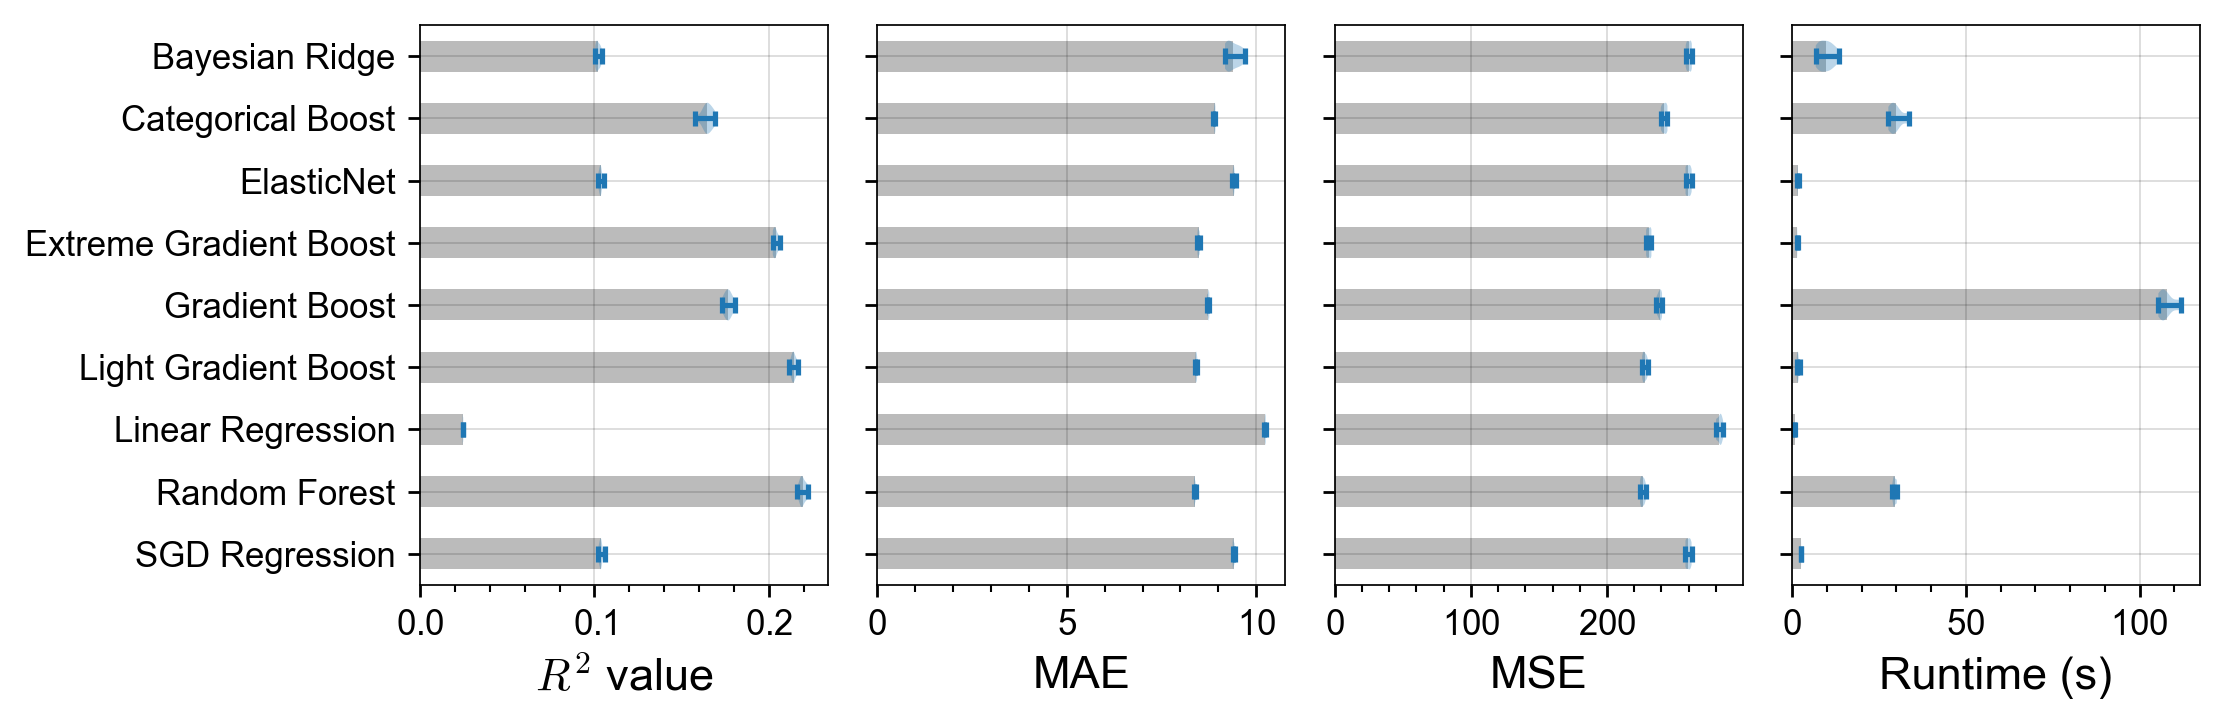

In [11]:
def fig_compare_models(perf=model_perf, size=(9, 3), dpi=150):
    df = perf.sort_values('name', ascending=0)
    cols = [('r2_score', '$R^2$ value', 'dodgerblue'),
            ('mean_absolute_error', 'MAE', 'limegreen'),
            ('mean_squared_error', 'MSE', 'orange'),
            ('runtime', 'Runtime (s)', 'tomato')]
    _, axes = plt.subplots(1, len(cols), figsize=size, dpi=dpi, sharey=True)
    for i, (col, xlab, color) in enumerate(cols):
        ax = pplot(axes[i])
        df.groupby('name')[col].mean().plot.barh(ax=ax, color='#bbb')
        ax.violinplot(df.pivot_table(col, 'seed', 'name'), vert=False,
                      positions=range(df['name'].nunique()))
        ax.tick_params(which='minor', left=False)
        ax.set_xlabel(xlab)
        if i != 0: ax.set_yticklabels([])
        if i == 0: ax.set_yticklabels(df.name.unique())
    ax = axes[0]; ax.set_yticklabels(df.name.unique()); ax.set_ylabel('')
    plt.tight_layout()
    
fig_compare_models(dpi=250)

## Compute SHAP

In [12]:
def get_shap(model, vars_, top=None, wtd=False,
             test_ratio=0.3, data=data, seed=1234):
    res = []
    for var in tqdm(vars_):
        ds = Dataset(var, test_ratio, seed=seed)
        model.fit(ds.Xtrain, ds.ytrain, ds.wtrain if wtd else None)
        explainer = shap.TreeExplainer(model, seed=seed)
        shaps = np.abs(explainer(ds.Xtest).values).mean(0)
        shaps = Pdf(D(feature=ds.X.columns, shap=shaps))
        res.append(shaps.assign(var=var))
    return pd.concat(res).reset_index(drop=1)

model = lgbm.LGBMRegressor(force_row_wise=True, verbose=-1)
%time shaps = get_shap(model, ['LogDistance', 'Duration']).disp() # t=0:19

  0%|          | 0/2 [00:00<?, ?it/s]

52 rows x 3 cols; Memory: 0.0 MiB


feature       shap          var
   <object>  <float64>     <object>
0      Mode   0.159508  LogDistance

CPU times: user 15min 6s, sys: 2.62 s, total: 15min 9s
Wall time: 19.4 s


## Finalize relevant features

/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/matplotlib/ticker.py:2937: RuntimeWarning:

invalid value encountered in log10



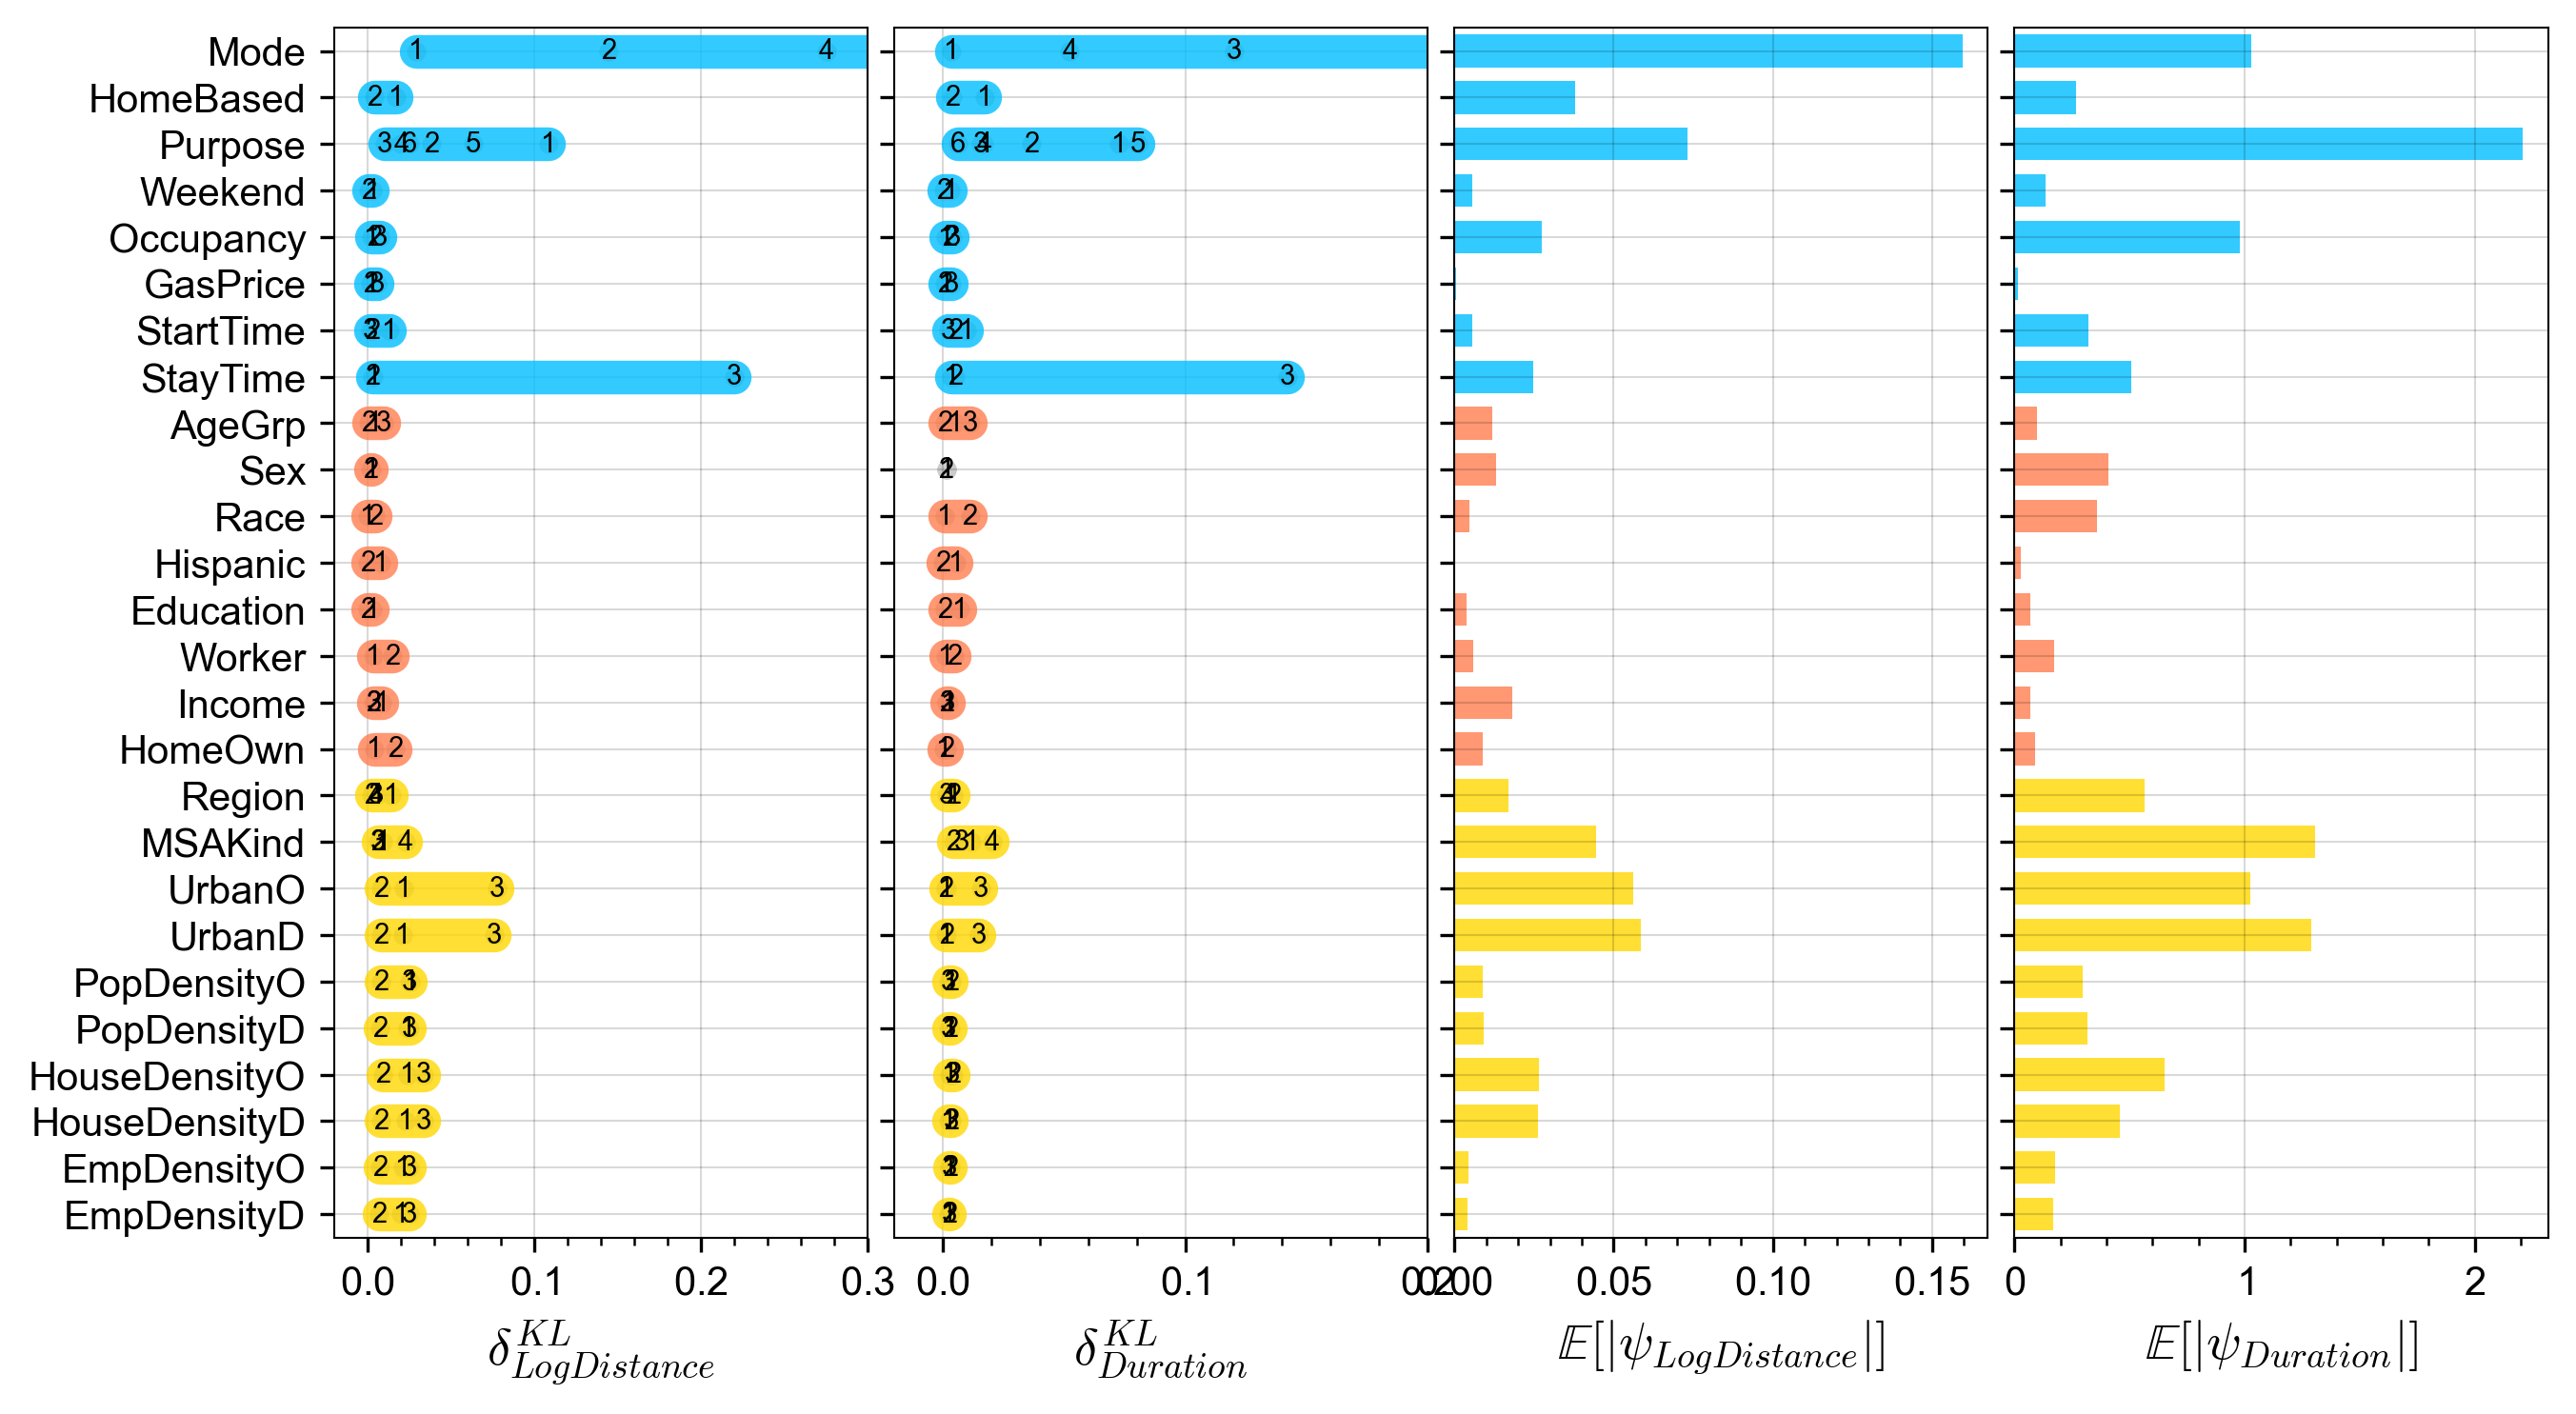

In [13]:
def fig_feature_selection(data, shaps=shaps, size=(10, 5.5), dpi=150):
    hist = lambda df: np.histogram(df.val, bins=100, weights=df.TripWeight, density=1)[0]
    kld = [] # table containing entropy values
    features = data.select_dtypes(CAT).columns
    for var, vmin, vmax in [('LogDistance', 2, 5), ('Duration', 0, 90)]:
        data = data.assign(val=data[var].clip(vmin, vmax)).reset_index()
        all_hist = hist(data)
        for feat in features: # for each feature
            for j, (cat, df) in enumerate(data.groupby(feat)): # for each level
                value = entropy(hist(df), all_hist)
                kld.append(D(var=var, feature=feat, cat_id=j, cat=cat, value=value))
    kld = Pdf(kld)
    res = (kld.groupby(['var', 'feature'])['value'].agg(['min', 'max'])
           .rename(columns='kl_{}'.format).reset_index()
           .merge(shaps, on=('var', 'feature')))
    res.feature = pd.Categorical(res.feature, categories=features)
    res['group'] = pd.cut(res.feature.cat.codes, [-1, 7, 15, INF], labels=['Trip', 'SES', 'OD'])
    res['color'] = res.group.map(D(Trip='deepskyblue', SES='coral', OD='gold'))
    res['pos'] = len(features) - res.feature.cat.codes - 1
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi, sharey=True)
    for i, (var, vmax) in enumerate([('LogDistance', 0.3), ('Duration', 0.2)]):
        ## KL divergence
        ax = pplot(axes[i], xlab='$\delta^{KL}_{%s}$' % var, xlog=0, xlim=(-0.02, vmax))
        df = kld.merge(res, on=('var', 'feature')).query(f'var=="{var}"')
        ax.scatter(df.value, df.pos, s=15, color='#ccc')
        for _, r in df.iterrows():
            if r.value > vmax: continue
            ax.text(r.value, r.pos, str(r.cat_id + 1), fontsize=7,
                    color='k', ha='center', va='center')
        df = res[res['var'] == var].sort_values('feature')
        for _, r in df.iterrows():
            ax.add_artist(mpl.lines.Line2D(
                [r.kl_min, r.kl_max], [r.pos] * 2, lw=8.5,
                alpha=0.8, color=r.color, solid_capstyle='round'))
        ## SHAP values
        ax = pplot(axes[i + 2], xlab='$\mathbb{E}[|\psi_{%s}|]$' % var)
        ax.barh(df.pos, df.shap, tick_label=df.feature, color=df.color, alpha=0.8, height=0.7)
    for i, ax in enumerate(axes):
        ax.set_ylim(-0.5, len(features) - 0.5)
        ax.tick_params(which='minor', left=False)
    plt.subplots_adjust(wspace=0.05)

x = fig_feature_selection(data, shaps, dpi=300); x

## Important distributions

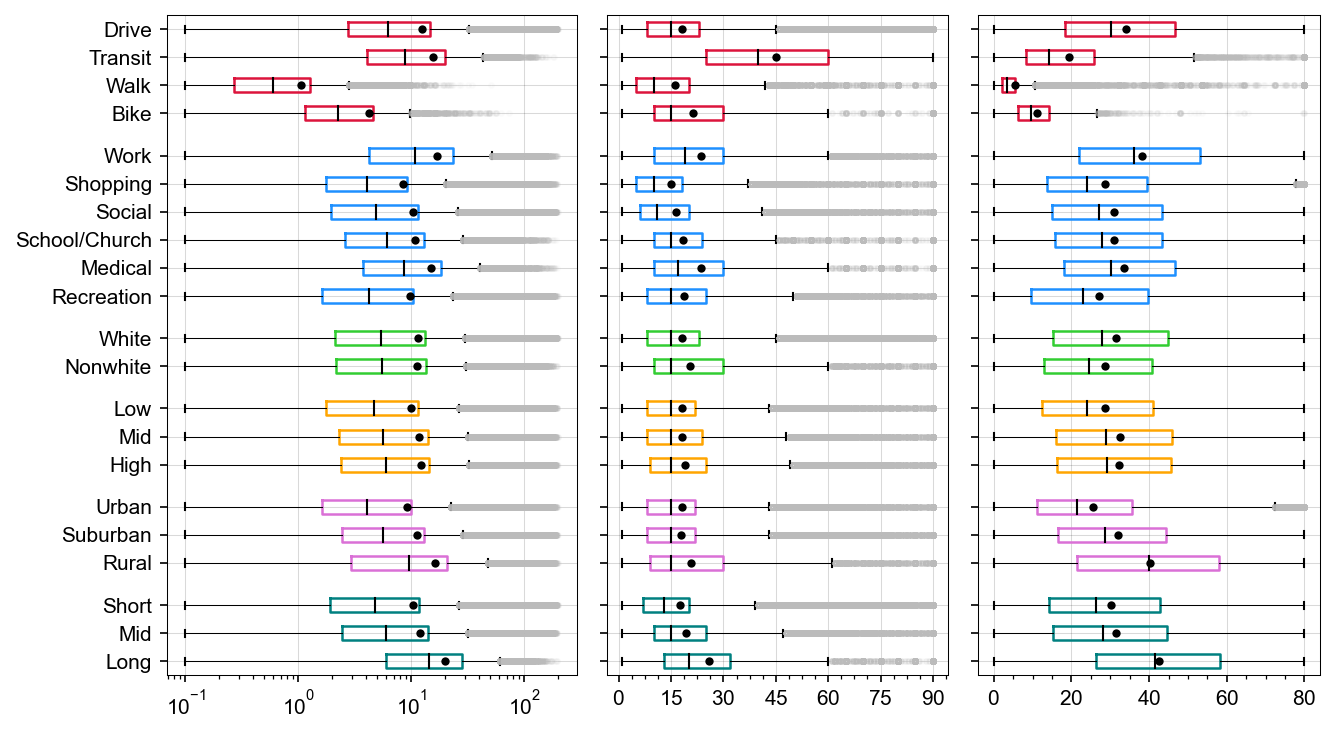

In [14]:
def plot_distr_box(data=data, size=(9, 5), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi, 
                             gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    cols = D(Mode='crimson', Purpose='dodgerblue', Race='limegreen',
             Income='orange', UrbanO='orchid', StayTime='teal')
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, var, rng, title in [(0, 'Distance', (0.1, 1000), 'Trip length (km)'),
                               (1, 'Duration', (0, 90), 'Trip duration (min)'),
                               (2, 'Speed', (0, 80), 'Speed (km/h)')]:
        df = Pdf(sum([[D(col=col, cat=x[0].title().replace('_', ' '),
                         vals=x[1].values, pos=i / 2, n=ticker(len(x[1]))) 
                       for x in data.groupby(col)[var]]
                      for i, col in enumerate(cols.keys())], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(cols)
        ax = pplot(axes[j], xlog=var == 'Distance')
        x = ax.boxplot(df.vals, positions=df.pos + df.index,
                       labels=df.cat,# + ' (' + df.n + ')',
                       vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2),
                       flierprops=D(markersize=2, markeredgecolor='#bbb1'),
                       showmeans=True, meanline=False, meanprops=D(
                           marker='o', markersize=4, 
                           markeredgecolor='none', markerfacecolor='k'),
                       medianprops=D(color='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if var == 'Duration': ax.set_xticks(np.arange(0, 91, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()

x = plot_distr_box(dpi=150); x

# 4. Density & urbanity

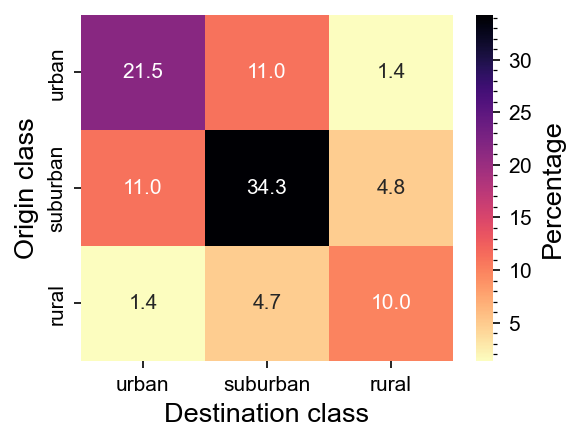

In [15]:
ax = pplot(size=(4, 3), dpi=150)
sns.heatmap(data[['UrbanO', 'UrbanD']].value_counts()
            .pipe(lambda x: x / x.sum() * 100).reset_index()
            .pivot_table('count', 'UrbanO', 'UrbanD'),
            ax=ax, cmap='magma_r', annot=True, fmt='.1f',
            cbar_kws=D(label='Percentage'))
ax.minorticks_off(); ax.grid(False)
ax = pplot(ax, xlab='Destination class', ylab='Origin class')